<a href="https://colab.research.google.com/github/imenebak/University-of-Liverpool-ion-switching/blob/master/Ion_Switching_SignalEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Ion channels** 
are pore-forming membrane proteins that allow ions to pass through the channel pore. Ion channels are "closed" when they do not allow ions to pass through and "open" when they allow ions to pass through. Ion channels are especially prominent components of the nervous system. In addition, they are key components in a wide variety of biological processes that involve rapid changes in cells, such as cardiac, skeletal, and smooth muscle contraction, epithelial transport of nutrients and ions, T-cell activation and pancreatic beta-cell insulin release.


---

The pivotal role of ion channels in several biological processes makes it an excellent way to discover new drugs and medicines for various diseases.


---


Therefore, finding a relationship between current signals and open ion channels can unlock new possibilities in the fields of medicine and environmental studies. And hence this competition.

In [1]:
import os
import gc
import time
import math
from numba import jit
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt 
from statsmodels.robust import mad

import scipy
from scipy import signal
from scipy.signal import butter, deconvolve

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [9]:
SAMPLE_RATE = 25
SIGNAL_LEN = 1000

In [ ]:
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [8]:
!kaggle competitions download -c liverpool-ion-switching

  0% 0.00/4.27M [00:00<?, ?B/s]
100% 4.27M/4.27M [00:00<00:00, 70.7MB/s]
 49% 13.0M/26.6M [00:00<00:00, 47.0MB/s]
100% 26.6M/26.6M [00:00<00:00, 88.5MB/s]
 91% 9.00M/9.91M [00:00<00:00, 92.4MB/s]
100% 9.91M/9.91M [00:00<00:00, 90.0MB/s]


In [15]:
!touch sample_submission.csv

In [16]:
TEST_PATH = "/content/test.csv.zip"
TRAIN_PATH = "/content/train.csv.zip"
SUBMISSION_PATH = "/content/sample_submission.csv"

In [17]:
test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)
test_data.drop(columns=['time'], inplace=True)

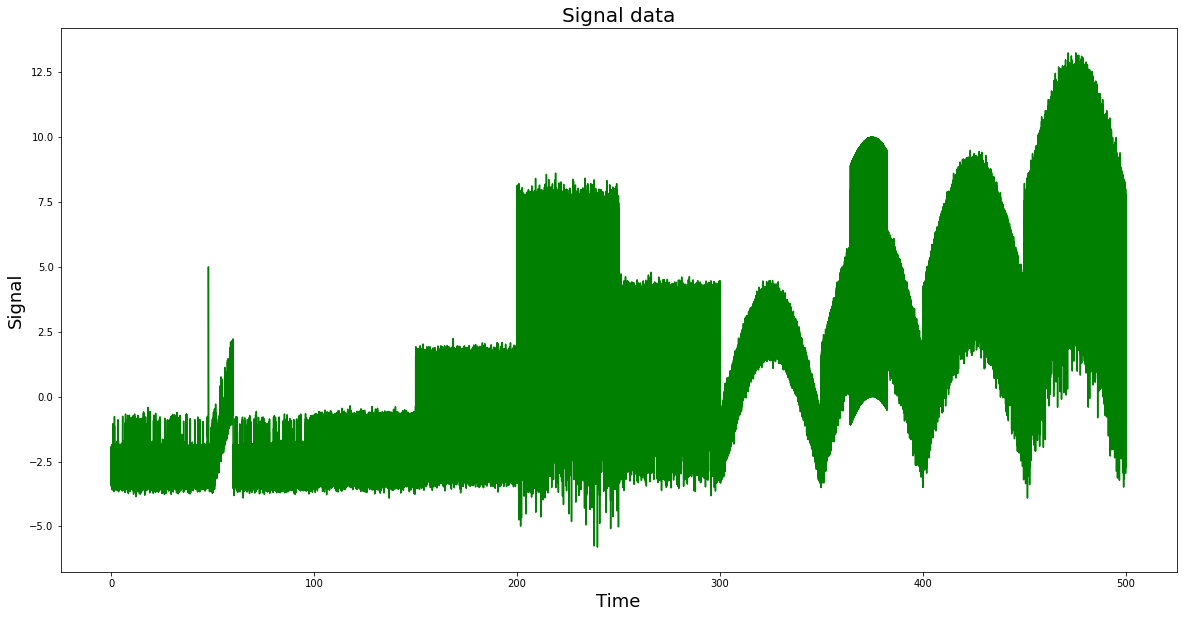

In [21]:
plt.figure(figsize=(20, 10))
plt.plot(train_data["time"], train_data["signal"], color="g")
plt.title("Signal data", fontsize=20)
plt.xlabel("Time", fontsize=18)
plt.ylabel("Signal", fontsize=18)
plt.show()

In [22]:
fig = make_subplots(rows=3, cols=1)

x_1 = train_data.loc[:100]["time"]
y_1 = train_data.loc[:100]["signal"]
x_2 = train_data.loc[100:200]["time"]
y_2 = train_data.loc[100:200]["signal"]
x_3 = train_data.loc[200:300]["time"]
y_3 = train_data.loc[200:300]["signal"]

fig.add_trace(go.Scatter(x=x_1, y=y_1, showlegend=False,
                    mode='lines+markers', name="First sample",
                         marker=dict(color="dodgerblue")),
             row=1, col=1)

fig.add_trace(go.Scatter(x=x_2, y=y_2, showlegend=False,
                    mode='lines+markers', name="Second sample",
                         marker=dict(color="mediumseagreen")),
             row=2, col=1)

fig.add_trace(go.Scatter(x=x_3, y=y_3, showlegend=False,
                    mode='lines+markers', name="Third sample",
                         marker=dict(color="violet")),
             row=3, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample signals")
fig.show()

**Denoising**
signals can be denoised in order to extract the underlying trend from the signal. This method may lose some information from the original signal, but it may be useful in extracting certain features regarding the trends in the time series.

**Wavelet denoising**
a way to remove the unnecessary noise from a signal. This method calculates coefficients called the "wavelet coefficients". These coefficients decide which pieces of information to keep (signal) and which ones to discard (noise).

To removed noise from the electric signal :
 

*   We use of the MAD value (mean absolute deviation) to understand the randomness in the signal and accordingly decide the minimum threshold for the wavelet coefficients in the time series.
*   We filter out the low coefficients from the wavelet coefficients and reconstruct the electric signal from the remaining coefficients.

In [25]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
  coeff = pywt.wavedec(x, wavelet, mode="per")
  sigma = (1/0.6745) * maddest(coeff[-level])

  uthresh = sigma * np.sqrt(2*np.log(len(x)))
  coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

  return pywt.waverec(coeff, wavelet, mode='per')

In [26]:
x = train_data.loc[:100]["time"]
y1 = train_data.loc[:100]["signal"]
y_w1 = denoise_signal(train_data.loc[:100]["signal"])
y2 = train_data.loc[100:200]["signal"]
y_w2 = denoise_signal(train_data.loc[100:200]["signal"])
y3 = train_data.loc[200:300]["signal"]
y_w3 = denoise_signal(train_data.loc[200:300]["signal"])

In [27]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=x, mode='lines+markers', y=y1, marker=dict(color="lightskyblue"), showlegend=False,
               name="Original signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=x, y=y_w1, mode='lines', marker=dict(color="navy"), showlegend=False,
               name="Denoised signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=x, mode='lines+markers', y=y2, marker=dict(color="mediumaquamarine"), showlegend=False),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=x, y=y_w2, mode='lines', marker=dict(color="darkgreen"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=x, mode='lines+markers', y=y3, marker=dict(color="thistle"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=x, y=y_w3, mode='lines', marker=dict(color="indigo"), showlegend=False),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Original (pale) vs. Denoised (dark) signals")
fig.show()

In the above graphs, the dark lineplots represent the denoised signals and the light lineplots represent the original signals. We can see that the wavelet denoising method is able to successfully capture the trend in the signal, while ignoring the noise at the same time. These trends can be used to calculate useful features for modeling.

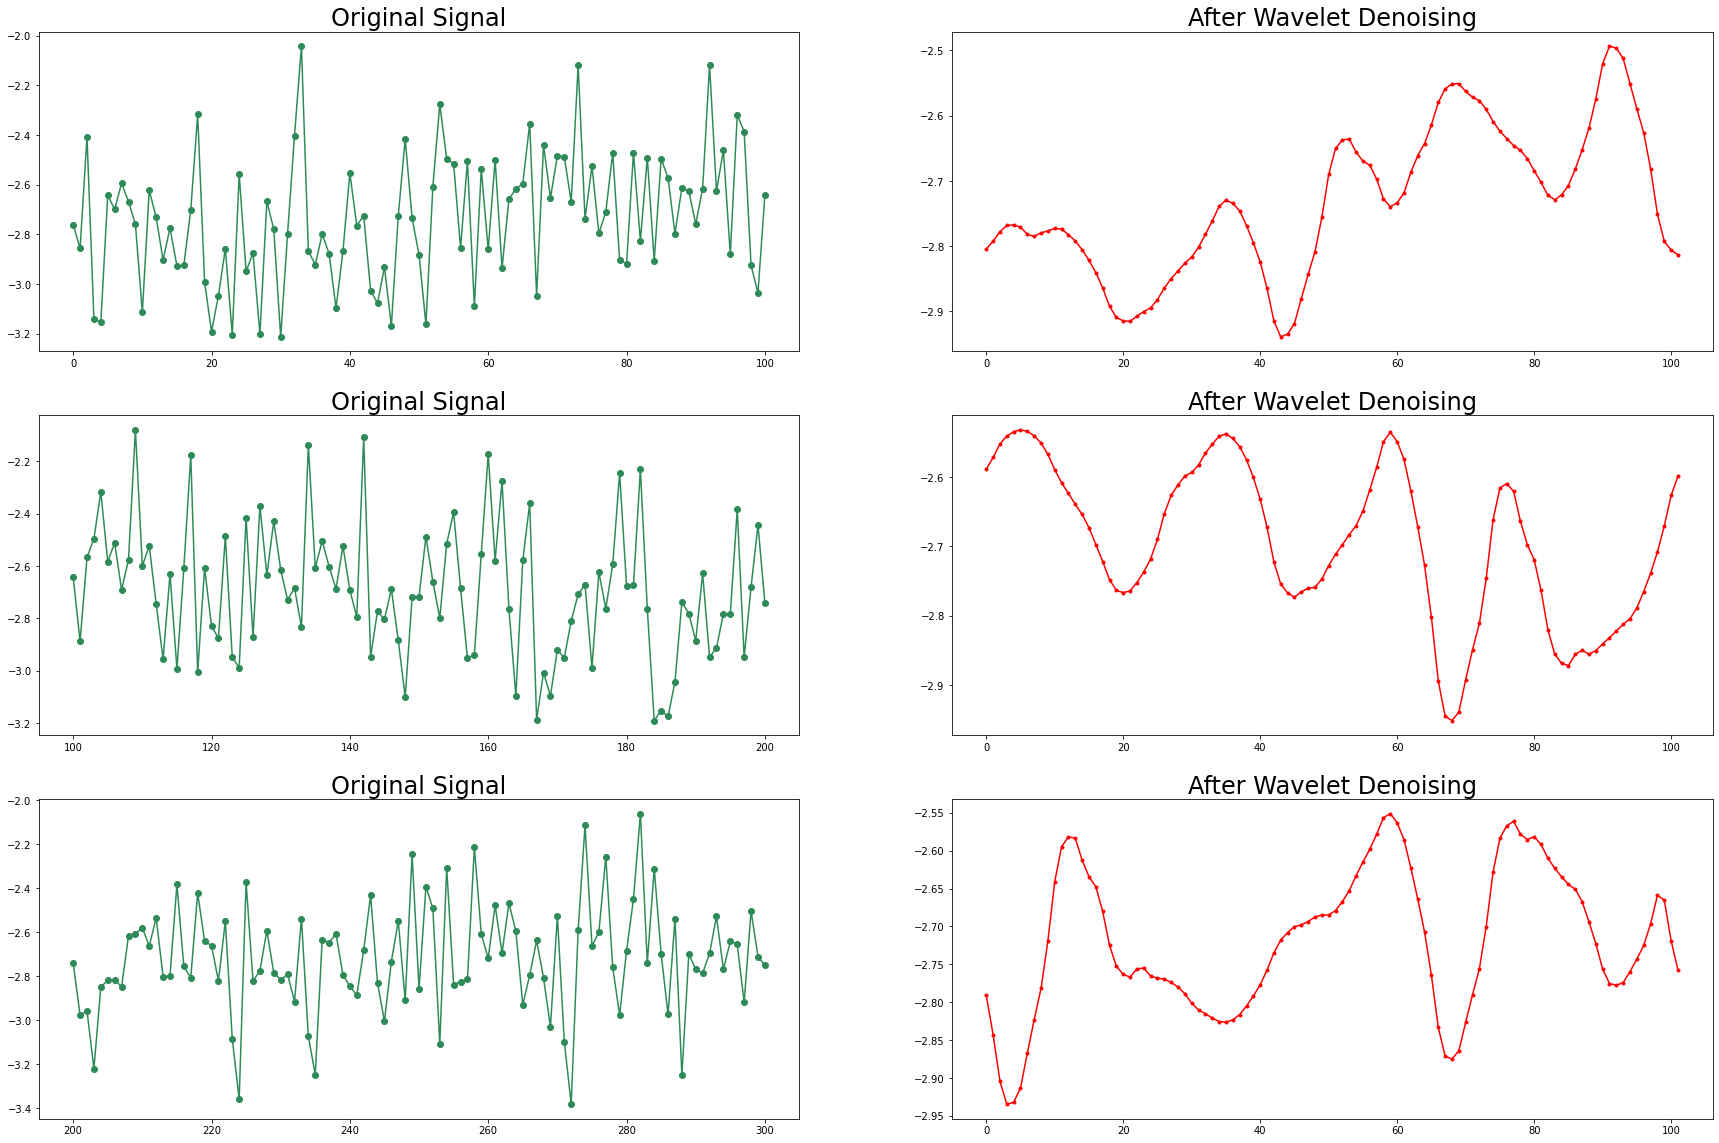

In [28]:
#The below graphs illustrate these graphs side-by-side. 
#Red graphs represent original signals and green graphs represent denoised signals.
x = train_data.loc[:100]["time"]
y1 = train_data.loc[:100]["signal"]
y_w1 = denoise_signal(train_data.loc[:100]["signal"])
y2 = train_data.loc[100:200]["signal"]
y_w2 = denoise_signal(train_data.loc[100:200]["signal"])
y3 = train_data.loc[200:300]["signal"]
y_w3 = denoise_signal(train_data.loc[200:300]["signal"])

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(30, 20))

ax[0, 0].plot(y1, color='seagreen', marker='o') 
ax[0, 0].set_title('Original Signal', fontsize=24)
ax[0, 1].plot(y_w1, color='red', marker='.') 
ax[0, 1].set_title('After Wavelet Denoising', fontsize=24)

ax[1, 0].plot(y2, color='seagreen', marker='o') 
ax[1, 0].set_title('Original Signal', fontsize=24)
ax[1, 1].plot(y_w2, color='red', marker='.') 
ax[1, 1].set_title('After Wavelet Denoising', fontsize=24)

ax[2, 0].plot(y3, color='seagreen', marker='o') 
ax[2, 0].set_title('Original Signal', fontsize=24)
ax[2, 1].plot(y_w3, color='red', marker='.') 
ax[2, 1].set_title('After Wavelet Denoising', fontsize=24)

plt.show()

**Average smoothing**
a relatively simple way to denoise signals. In this method, we take a "window" with a fixed size (like 10). We first place the window at the beginning of the time series (first ten elements) and calculate the mean of that section. We now move the window across the time series in the forward direction by a particular "stride", calculate the mean of the new window and repeat the process, until we reach the end of the time series. All the mean values we calculated are concatenated into a new time series, which forms the denoised signal.

In [29]:
def average_smoothing(signal, kernel_size=3, stride=1):
    sample = []
    start = 0
    end = kernel_size
    while end <= len(signal):
        start = start + stride
        end = end + stride
        sample.extend(np.ones(end - start)*np.mean(signal[start:end]))
    return np.array(sample)

In [30]:
x = train_data.loc[:100]["time"]
y1 = train_data.loc[:100]["signal"]
y_a1 = average_smoothing(train_data.loc[:100]["signal"])
y2 = train_data.loc[100:200]["signal"]
y_a2 = average_smoothing(train_data.loc[100:200]["signal"])
y3 = train_data.loc[200:300]["signal"]
y_a3 = average_smoothing(train_data.loc[200:300]["signal"])

In [32]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=x, mode='lines+markers', y=y1, marker=dict(color="lightskyblue"), showlegend=False,
               name="Original signal"),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=x, y=y_a1, mode='lines', marker=dict(color="navy"), showlegend=False,
               name="Denoised signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=x, mode='lines+markers', y=y2, marker=dict(color="mediumaquamarine"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=x, y=y_a2, mode='lines', marker=dict(color="darkgreen"), showlegend=False),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=x, mode='lines+markers', y=y3, marker=dict(color="thistle"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=x, y=y_a3, mode='lines', marker=dict(color="indigo"), showlegend=False),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Original (pale) vs. Denoised (dark) signals")
fig.show()

# **Open channels**

In [33]:
signals = []
targets = []

train = train_data # shuffle(train_data).reset_index(drop=True)
for i in range(4000):
    min_lim = SIGNAL_LEN * i
    max_lim = SIGNAL_LEN * (i + 1)
    
    signals.append(list(train["signal"][min_lim : max_lim]))
    targets.append(train["open_channels"][max_lim])
    
signals = np.array(signals)
targets = np.array(targets)

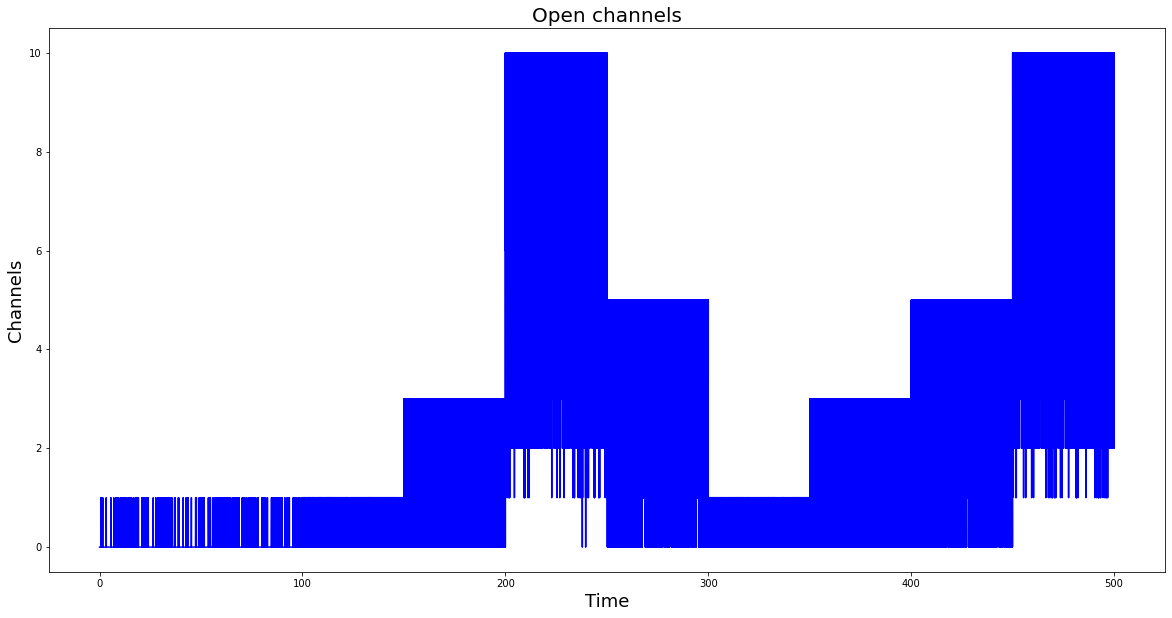

In [34]:
plt.figure(figsize=(20, 10))
plt.plot(train_data["time"], train_data["open_channels"], color="b")
plt.title("Open channels", fontsize=20)
plt.xlabel("Time", fontsize=18)
plt.ylabel("Channels", fontsize=18)
plt.show()

In [35]:
fig = go.Figure(data=[
    go.Bar(x=list(range(11)), y=train_data['open_channels'].value_counts(sort=False).values)
])

fig.update_layout(title='Target (open_channels) distribution')
fig.show()

*From the above graph, we can see that open_channels has a discrete probability distribution, with values ranging from 0 to 10 occuring in the training data. The proability generally seems to decrease exponentially with increase in open_channels. THis means that a high number of open channels is more unlikely than a smaller number of open channels. Maybe, a closed state is a more stable than an open state for an ion channel, and so it is more likely to have a lower number of open channels.*

In [36]:
fig = make_subplots(rows=5, cols=2, subplot_titles=["Batch #{}".format(i) for i in range(10)])
i = 0

for row in range(1, 6):
    for col in range(1, 3):   
        
        data = train_data.iloc[(i * 500000):((i+1) * 500000 + 1)]['open_channels'].value_counts(sort=False).values
        fig.add_trace(go.Bar(x=list(range(11)), y=data), row=row, col=col)
        
        i += 1

fig.update_layout(title_text="Target distribution in different batches", height=1200, showlegend=False)
fig.show()

# **Signal data vs. Open channels**

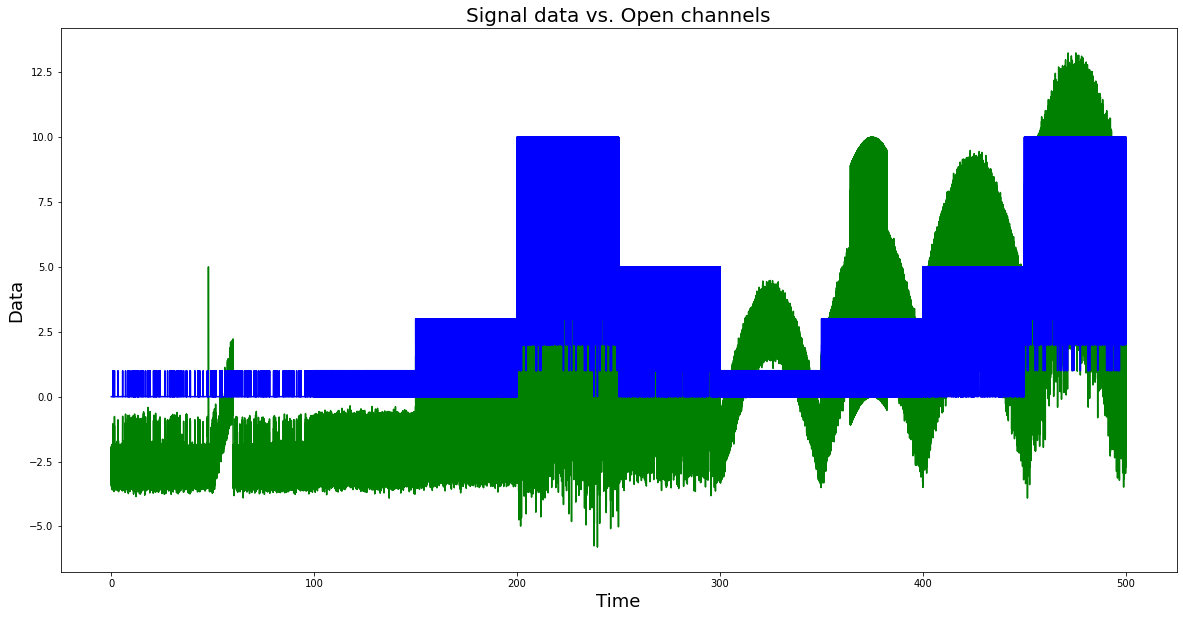

In [38]:
plt.figure(figsize=(20, 10))
plt.plot(train_data["time"], train_data["signal"], color="g")
plt.plot(train_data["time"], train_data["open_channels"], color="b")
plt.title("Signal data vs. Open channels", fontsize=20)
plt.xlabel("Time", fontsize=18)
plt.ylabel("Data", fontsize=18)
plt.show()

*From the above graph (signal in red and open channels in blue), we can see that there is a clear link between the volatility in signal and the volatility in open channels. Above t = 300, we can see a trend of the form y = sin2(x), but with monotonously increasing amplitudes in the signal data. The period of the signal's oscillation perfectly matches with that of the open channels. The maximum value of open channels tends to increase as the amplitude of the signal increasing, giving the open_channels graph a "step function" sort of shape above t = 300. This is clear evidence of the effect of signal volatility on the ion channels.*

# **Measures of complexity (entropy and fractal dimension)**

In [41]:
def _embed(x, order=3, delay=1):
    N = len(x)
    if order * delay > N:
        raise ValueError("Error: order * delay should be lower than x.size")
    if delay < 1:
        raise ValueError("Delay has to be at least 1.")
    if order < 2:
        raise ValueError("Order has to be at least 2.")
    Y = np.zeros((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[i * delay:i * delay + Y.shape[1]]
    return Y.T

all = ['perm_entropy', 'spectral_entropy', 'svd_entropy', 'app_entropy',
       'sample_entropy']

In [42]:
def perm_entropy(x, order=3, delay=1, normalize=False):
    x = np.array(x)
    ran_order = range(order)
    hashmult = np.power(order, ran_order)
    # Embed x and sort the order of permutations
    sorted_idx = _embed(x, order=order, delay=delay).argsort(kind='quicksort')
    # Associate unique integer to each permutations
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    # Return the counts
    _, c = np.unique(hashval, return_counts=True)
    # Use np.true_divide for Python 2 compatibility
    p = np.true_divide(c, c.sum())
    pe = -np.multiply(p, np.log2(p)).sum()
    if normalize:
        pe /= np.log2(factorial(order))
    return pe

In [44]:
df = pd.DataFrame(np.transpose([[perm_entropy(row) for row in signals], targets]))
df.columns = ["perm_entropy", "open_channels"]
fig = go.Figure()

channels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for channel in channels:
    fig.add_trace(go.Box(x=df['open_channels'][df['open_channels'] == channel],
                         y=df['perm_entropy'][df['open_channels'] == channel],
                         name=channel,
                         marker=dict(color='blueviolet'), showlegend=False)
                         )
fig.add_trace(go.Scatter(x=channels,
                         y=[df['perm_entropy'][df['open_channels'] == channel].median() for channel in channels],
                         mode="lines+markers",
                         name=channel,
                         marker=dict(color='blueviolet'), showlegend=False)
                         )

fig.update_layout(title="Permutation entropy vs. Open channels", xaxis_title="Open channels", yaxis_title="Permutation entropy")
fig.show()

In [45]:
df = pd.DataFrame(np.transpose([[perm_entropy(row) for row in signals], targets]))
df.columns = ["perm_entropy", "open_channels"]
fig = go.Figure()

channels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fig.add_trace(go.Scatter(x=channels,
                         y=[df['perm_entropy'][df['open_channels'] == channel].median() for channel in channels],
                         mode="lines+markers",
                         name=channel,
                         marker=dict(color='blueviolet'), showlegend=False)
                         )

fig.update_layout(title="Median permutation entropy vs. Open channels", xaxis_title="Open channels", yaxis_title="Median permutation entropy")
fig.show()

*From the above graphs, we can see that the distribution of permutation entropy is different for different values of open_channels. The distribution at open_channels = 10 has the lowest median. This suggests that higher open_channels values are linked with less complex or volatile signals. The only exception to this trend is open_channels = 6 where we see a sharp dip in permutation entropy. Besides this, all distributions seem to have a median between 2.56 and 2.58. All distributions have a clear leftward (negative) skew as well.*



---
References :



1.   Kaggle ION Liverpol university competition
2.   Tarunpaparaju work contribution


